# LGU+ 경진대회 - 베이스라인  
- [Neural Collaborative Filtering(NCF)](https://arxiv.org/pdf/1708.05031.pdf) 논문의 NeuMF를 참고하여 side-information을 결합한 모델을 PyTorch로 구현
- 구현된 모델의 검증 데이터셋과 리더보드의 성능을 확인

## 목차 
- 데이터 전처리 
    - 기본 설정
    - 데이터 불러오기 
    - 학습 및 검증 데이터 생성 
- NeuMF 구현    
    - 모델 구현 
    - 학습 및 추론 코드 구현
- 모델 학습 
    - 하이퍼파라미터 설정 & 최적화 기법 설정
    - 모델 학습 
    - 학습 과정 시각화 
- 제출 
    - 모든 유저에 대해 추천 결과 생성
    - 저장 

## 데이터 전처리
### 기본 설정

In [15]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm as tq
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F


import plotnine
from plotnine import *


In [16]:
# 하이퍼파라미터 
class cfg: 
    gpu_idx = 0
    device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")
    top_k = 25
    seed = 42
    neg_ratio = 100
    test_size = 0.2

In [17]:
# 시드 고정 
def seed_everything(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
seed_everything(cfg.seed)

In [18]:
# 경로 설정
data_path = '../data'
saved_path = './saved'
output_path = './submission'

### 데이터 불러오기
- history_data : 시청 시작 데이터
- profile_data : 프로필 정보 
- meta_data : 콘텐츠 일반 메타 정보

In [19]:
# 데이터 불러오기 
history_df = pd.read_csv(os.path.join(data_path, 'history_data.csv'), encoding='utf-8')
profile_df = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')
meta_df = pd.read_csv(os.path.join(data_path, 'meta_data.csv'), encoding='utf-8')

In [20]:
print(history_df.shape,profile_df.shape,meta_df.shape)

(1005651, 8) (8311, 9) (42602, 16)


### 학습 및 검증 데이터 생성 
- train : 시청 이력의 80%를 사용 
- valid : 시청 이력의 20%를 사용 

In [21]:
# 데이터 전처리 (중복제거) 
# 참고 : drop_duplicates의 subset을 무엇으로 구성하냐에 따라서 제거되는 항목들이 다름 
# ex) 'profile_id', 'album_id' : 중복된 시청이력 모두 제거 / 'profile_id', 'album_id', 'log_time' : 같은 시간에 시청한 이력만 제거 
data = history_df[['profile_id', 'log_time', 'album_id']].drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).sort_values(by = ['profile_id', 'log_time']).reset_index(drop = True)
data['rating'] = 1

cfg.n_users = data.profile_id.max()+1
cfg.n_items = data.album_id.max()+1

In [22]:
data

,profile_id,log_time,album_id,rating
0,3,20220301115719,15,1
1,3,20220301115809,16,1
2,3,20220301115958,17,1
3,3,20220301120118,18,1
4,3,20220301120229,19,1
...,...,...,...,...
899247,33032,20220427155668,381,1
899248,33032,20220427155680,381,1
899249,33032,20220427155810,125,1
899250,33032,20220427155838,125,1


In [23]:
# 학습 및 검증 데이터 분리
train, valid = train_test_split(
    data, test_size=cfg.test_size, random_state=cfg.seed,
)
print('학습 데이터 크기:', train.shape)
print('검증 데이터 크기:', valid.shape)

학습 데이터 크기: (719401, 4)
검증 데이터 크기: (179851, 4)


In [24]:
# Matrix 형태로 변환 
train = train.to_numpy()
matrix = sparse.lil_matrix((cfg.n_users, cfg.n_items))
for (p, _, i, r) in tq(train):
    matrix[p, i] = r
    
train = sparse.csr_matrix(matrix)
train = train.toarray()
print("train 형태: \n", train)

100%|██████████| 719401/719401 [00:02<00:00, 321290.49it/s]


train 형태: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [25]:
train.shape

(33033, 25917)

In [26]:
# 유저 특징 정보 추출 
profile_df = profile_df.set_index('profile_id')
user_features = profile_df[['age']].to_dict()

print("user_id 3의 age 정보 :", user_features['age'][3])

user_id 3의 age 정보 : 5


In [27]:
len(user_features['age'])

8311

In [28]:
# 아이템 특징 정보 추출 
meta_df = meta_df.set_index('album_id')

# 범주형 데이터를 수치형 데이터로 변경 
le = LabelEncoder()
meta_df['genre_mid'] = le.fit_transform(meta_df['genre_mid'])
item_features = meta_df[['genre_mid']].to_dict()
print("album_id 749의 genre_mid 정보 :", item_features['genre_mid'][749])

album_id 749의 genre_mid 정보 : 1


In [29]:
meta_df[['genre_mid']]

,genre_mid
album_id,
749,1
750,1
2131,1
2625,1
2594,1
...,...
39873,5
39874,5
4779,23


In [30]:
len(item_features['genre_mid'])

39875

In [31]:
# 추출한 특징 정보의 속성을 저장 
cfg.n_genres = meta_df['genre_mid'].nunique()
cfg.n_continuous_feats = 1 

In [32]:
cfg.n_genres

29

## NeuMF 구현


### 모델 구현 
- [Neural Collaborative Filtering(NCF)](https://arxiv.org/pdf/1708.05031.pdf) 논문의 NeuMF를 참고하여 side-information을 결합한 모델을 PyTorch로 구현
    - continuous feature (age)와 categorical feature (genre_mid)를 같이 학습할 수 있도록 결합

![](http://drive.google.com/uc?export=view&id=1tpajTLipLoFdvLICO-alAxeoKAE8-k61)

In [30]:
class NeuMF(nn.Module):
    """Neural Matrix Factorization Model
        참고 문헌 : https://arxiv.org/abs/1708.05031

    예시 :
        model = NeuMF(cfg) 
        output = model.forward(user_ids, item_ids, [feat0, feat1]) 
    """
    def __init__(self, cfg):
        """ 
        Args:
            cfg : config 파일로 네트워크 생성에 필요한 정보들을 담고 있음 
        """
        super(NeuMF, self).__init__()
        self.n_users = cfg.n_users
        self.n_items = cfg.n_items
        self.emb_dim = cfg.emb_dim
        self.layer_dim = cfg.layer_dim
        self.n_continuous_feats = cfg.n_continuous_feats
        self.n_genres = cfg.n_genres
        self.dropout = cfg.dropout
        self.build_graph()

    def build_graph(self):
        """Neural Matrix Factorization Model 생성
            구현된 모습은 위의 그림을 참고 
        """
        self.user_embedding_mf = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mf = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
        
        self.user_embedding_mlp = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mlp = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
                
        self.genre_embeddig = nn.Embedding(num_embeddings=self.n_genres, embedding_dim=self.n_genres//2)
        
        self.mlp_layers = nn.Sequential(
            nn.Linear(2*self.emb_dim + self.n_genres//2 + self.n_continuous_feats, self.layer_dim), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout), 
            nn.Linear(self.layer_dim, self.layer_dim//2), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout)
        )
        self.affine_output = nn.Linear(self.layer_dim//2 + self.emb_dim, 1)
        self.apply(self._init_weights)
        

    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            normal_(module.weight.data, mean=0.0, std=0.01)
        elif isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)
    
    def forward(self, user_indices, item_indices, feats):
        """ 
        Args:
            user_indices : 유저의 인덱스 정보 
                ex) tensor([ 3100,  3100,  ..., 14195, 14195])
            item_indices : 아이템의 인덱스 정보
                ex) tensor([   50,    65,   ..., 14960, 11527])
            feats : 특징 정보 
        Returns: 
            output : 유저-아이템 쌍에 대한 추천 결과 
                ex) tensor([  9.4966,  22.0261, ..., -19.3535, -23.0212])
        """
        user_embedding_mf = self.user_embedding_mf(user_indices)
        item_embedding_mf = self.item_embedding_mf(item_indices)
        mf_output = torch.mul(user_embedding_mf, item_embedding_mf)
        
        user_embedding_mlp = self.user_embedding_mlp(user_indices)
        item_embedding_mlp = self.item_embedding_mlp(item_indices)
        genre_embedding_mlp = self.genre_embeddig(feats[1])
        input_feature = torch.cat((user_embedding_mlp, item_embedding_mlp, genre_embedding_mlp, feats[0].unsqueeze(1)), -1)
        mlp_output = self.mlp_layers(input_feature)
        
        output = torch.cat([mlp_output, mf_output], dim=-1)
        output = self.affine_output(output).squeeze(-1)
        return output

In [33]:
# 실험 mlp 2개 층 -> 5개 층(근거 논문)
class NeuMF(nn.Module):
    """Neural Matrix Factorization Model
        참고 문헌 : https://arxiv.org/abs/1708.05031

    예시 :
        model = NeuMF(cfg) 
        output = model.forward(user_ids, item_ids, [feat0, feat1]) 
    """
    def __init__(self, cfg):
        """ 
        Args:
            cfg : config 파일로 네트워크 생성에 필요한 정보들을 담고 있음 
        """
        super(NeuMF, self).__init__()
        self.n_users = cfg.n_users
        self.n_items = cfg.n_items
        self.emb_dim = cfg.emb_dim
        self.layer_dim = cfg.layer_dim
        self.n_continuous_feats = cfg.n_continuous_feats
        self.n_genres = cfg.n_genres
        self.dropout = cfg.dropout
        self.build_graph()

    def build_graph(self):
        """Neural Matrix Factorization Model 생성
            구현된 모습은 위의 그림을 참고 
        """
        self.user_embedding_mf = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mf = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
        
        self.user_embedding_mlp = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mlp = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
                
        self.genre_embeddig = nn.Embedding(num_embeddings=self.n_genres, embedding_dim=self.n_genres//2)
        
        self.mlp_layers = nn.Sequential(
            nn.Linear(2*self.emb_dim + self.n_genres//2 + self.n_continuous_feats, self.layer_dim), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout), 
            nn.Linear(self.layer_dim, self.layer_dim//2), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout),

            nn.Linear(self.layer_dim//2, self.layer_dim), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout),

            nn.Linear(self.layer_dim, self.layer_dim//2), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout),

            nn.Linear(self.layer_dim//2, self.layer_dim//2), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout)
        )
        self.affine_output = nn.Linear(self.layer_dim//2 + self.emb_dim, 1)
        self.apply(self._init_weights)
        

    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            normal_(module.weight.data, mean=0.0, std=0.01)
        elif isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)
    
    def forward(self, user_indices, item_indices, feats):
        """ 
        Args:
            user_indices : 유저의 인덱스 정보 
                ex) tensor([ 3100,  3100,  ..., 14195, 14195])
            item_indices : 아이템의 인덱스 정보
                ex) tensor([   50,    65,   ..., 14960, 11527])
            feats : 특징 정보 
        Returns: 
            output : 유저-아이템 쌍에 대한 추천 결과 
                ex) tensor([  9.4966,  22.0261, ..., -19.3535, -23.0212])
        """
        user_embedding_mf = self.user_embedding_mf(user_indices)
        item_embedding_mf = self.item_embedding_mf(item_indices)
        mf_output = torch.mul(user_embedding_mf, item_embedding_mf)
        
        user_embedding_mlp = self.user_embedding_mlp(user_indices)
        item_embedding_mlp = self.item_embedding_mlp(item_indices)
        genre_embedding_mlp = self.genre_embeddig(feats[1])
        input_feature = torch.cat((user_embedding_mlp, item_embedding_mlp, genre_embedding_mlp, feats[0].unsqueeze(1)), -1)
        mlp_output = self.mlp_layers(input_feature)
        
        output = torch.cat([mlp_output, mf_output], dim=-1)
        output = self.affine_output(output).squeeze(-1)
        return output

### 학습 및 추론 코드 구현

- 학습 : Negative sampling을 활용하여 Binary Classification 진행 
    - history 에 있는 album_id는 positive label로 그렇지 않은 album_id는 nagative label로 활용  
    - 단, 이때 모든 album_id를 negative label로 활용하는 것이 아닌 일부만 사용 (neg_ratio 값에 따라서 개수 조정)
- 추론 : 일부 데이터에 대해 recall, ndcg, coverage 성능 확인

#### 학습 및 추론에 필요한 데이터 셋 생성 코드 구현

In [34]:
def make_UIdataset(train, neg_ratio):
    """ 유저별 학습에 필요한 딕셔너리 데이터 생성 
    Args:
        train : 유저-아이템의 상호작용을 담은 행렬 
            ex) 
                array([[0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        ...,
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.]])
        neg_ratio : negative sampling 활용할 비율 
            ex) 3 (positive label 1개당 negative label 3개)
    Returns: 
        UIdataset : 유저별 학습에 필요한 정보를 담은 딕셔너리 
            ex) {'사용자 ID': [[positive 샘플, negative 샘플], ... , [1, 1, 1, ..., 0, 0]]}
                >>> UIdataset[3]
                    [array([   16,    17,    18, ...,  9586, 18991,  9442]),
                    array([5, 5, 5, ..., 5, 5, 5]),
                    array([4, 4, 4, ..., 5, 1, 1]),
                    array([1., 1., 1., ..., 0., 0., 0.])]
    """
    UIdataset = {}
    for user_id, items_by_user in enumerate(train):
        
        UIdataset[user_id] = []
        # positive 샘플 계산 
        pos_item_ids = np.where(items_by_user > 0.5)[0]
        num_pos_samples = len(pos_item_ids)

        # negative 샘플 계산 (random negative sampling) 
        num_neg_samples = neg_ratio * num_pos_samples
        neg_items = np.where(items_by_user < 0.5)[0]
        neg_item_ids = np.random.choice(neg_items, min(num_neg_samples, len(neg_items)), replace=False)
        UIdataset[user_id].append(np.concatenate([pos_item_ids, neg_item_ids]))
        
        # feature 추출 
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features['age'][user_id])
        UIdataset[user_id].append(np.array(features))
        
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(item_features['genre_mid'][item_id])
        UIdataset[user_id].append(np.array(features))
        
        # label 저장  
        pos_labels = np.ones(len(pos_item_ids))
        neg_labels = np.zeros(len(neg_item_ids))
        UIdataset[user_id].append(np.concatenate([pos_labels, neg_labels]))

    return UIdataset

In [35]:
UIdataset = make_UIdataset(train, neg_ratio=cfg.neg_ratio)

In [36]:
def make_batchdata(user_indices, batch_idx, batch_size):
    """ 배치 데이터로 변환 
    Args:
        user_indices : 전체 유저의 인덱스 정보 
            ex) array([ 3100,  1800, 30098, ...,  2177, 11749, 20962])
        batch_idx : 배치 인덱스 (몇번째 배치인지)
            ex) 0 
        batch_size : 배치 크기 
            ex) 256 
    Returns 
        batch_user_ids : 배치내의 유저 인덱스 정보 
            ex) [22194, 22194, 22194, 22194, 22194, ...]
        batch_item_ids : 배치내의 아이템 인덱스 정보 
            ex) [36, 407, 612, 801, 1404, ...]
        batch_feat0 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature0 정보 
            ex) [6, 6, 6, 6, 6, ...]
        batch_feat1 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature1 정보 
            ex) [4,  4,  4, 23,  4, ...]
        batch_labels : 배치내의 유저-아이템 인덱스 정보에 해당하는 label 정보 
            ex) [1.0, 1.0, 1.0, 1.0, 1.0, ...]
    """
    batch_user_indices = user_indices[batch_idx*batch_size : (batch_idx+1)*batch_size]
    batch_user_ids = []
    batch_item_ids = []
    batch_feat0 = []
    batch_feat1 = []
    batch_labels = []
    for user_id in batch_user_indices:
        item_ids = UIdataset[user_id][0]
        feat0 = UIdataset[user_id][1]
        feat1 = UIdataset[user_id][2]
        labels = UIdataset[user_id][3]
        user_ids = np.full(len(item_ids), user_id)
        batch_user_ids.extend(user_ids.tolist())
        batch_item_ids.extend(item_ids.tolist())
        batch_feat0.extend(feat0.tolist())
        batch_feat1.extend(feat1.tolist())
        batch_labels.extend(labels.tolist())
    return batch_user_ids, batch_item_ids, batch_feat0, batch_feat1, batch_labels

def update_avg(curr_avg, val, idx):
    """ 현재 epoch 까지의 평균 값을 계산 
    """
    return (curr_avg * idx + val) / (idx + 1)

#### 학습 및 검증 코드 생성

In [37]:
def train_epoch(cfg, model, optimizer, criterion): 
    model.train()
    curr_loss_avg = 0.0

    user_indices = np.arange(cfg.n_users)
    np.random.RandomState(cfg.epoch).shuffle(user_indices)
    batch_num = int(len(user_indices) / cfg.batch_size) + 1
    bar = tq(range(batch_num), leave=False)
    for step, batch_idx in enumerate(bar):
        user_ids, item_ids, feat0, feat1, labels = make_batchdata(user_indices, batch_idx, cfg.batch_size)
        # 배치 사용자 단위로 학습
        user_ids = torch.LongTensor(user_ids).to(cfg.device)
        item_ids = torch.LongTensor(item_ids).to(cfg.device)
        feat0 = torch.FloatTensor(feat0).to(cfg.device)
        feat1 = torch.LongTensor(feat1).to(cfg.device)
        labels = torch.FloatTensor(labels).to(cfg.device)
        labels = labels.view(-1, 1)

        # grad 초기화
        optimizer.zero_grad()

        # 모델 forward
        output = model.forward(user_ids, item_ids, [feat0, feat1])
        output = output.view(-1, 1)

        loss = criterion(output, labels)

        # 역전파
        loss.backward()

        # 최적화
        optimizer.step()    
        if torch.isnan(loss):
            print('Loss NAN. Train finish.')
            break
        curr_loss_avg = update_avg(curr_loss_avg, loss, step)
        
        msg = f"epoch: {cfg.epoch}, "
        msg += f"loss: {curr_loss_avg.item():.5f}, "
        msg += f"lr: {optimizer.param_groups[0]['lr']:.6f}"
        bar.set_description(msg)
        del user_ids,item_ids,feat0,feat1,labels,output
        torch.cuda.empty_cache()
        
    rets = {'losses': np.around(curr_loss_avg.item(), 5)}
    return rets

In [38]:
def recallk(actual, predicted, k = 25):
    """ label과 prediction 사이의 recall 평가 함수 
    Args:
        actual : 실제로 본 상품 리스트
        pred : 예측한 상품 리스트
        k : 상위 몇개의 데이터를 볼지 (ex : k=5 상위 5개의 상품만 봄)
    Returns: 
        recall_k : recall@k 
    """ 
    set_actual = set(actual)
    recall_k = len(set_actual & set(predicted[:k])) / min(k, len(set_actual))
    return recall_k

def unique(sequence):
    # preserves order
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

def ndcgk(actual, predicted, k = 25):
    set_actual = set(actual)
    idcg = sum([1.0 / np.log(i + 2) for i in range(min(k, len(set_actual)))])
    dcg = 0.0
    unique_predicted = unique(predicted[:k])
    for i, r in enumerate(unique_predicted):
        if r in set_actual:
            dcg += 1.0 / np.log(i + 2)
    ndcg_k = dcg / idcg
    return ndcg_k

def evaluation(gt, pred):
    """ label과 prediction 사이의 recall, coverage, competition metric 평가 함수 
    Args:
        gt : 데이터 프레임 형태의 정답 데이터 
        pred : 데이터 프레임 형태의 예측 데이터 
    Returns: 
        rets : recall, ndcg, coverage, competition metric 결과 
            ex) {'recall': 0.123024, 'ndcg': 056809, 'coverage': 0.017455, 'score': 0.106470}
    """    
    gt = gt.groupby('profile_id')['album_id'].unique().to_frame().reset_index()
    gt.columns = ['profile_id', 'actual_list']

    evaluated_data = pd.merge(pred, gt, how = 'left', on = 'profile_id')

    evaluated_data['Recall@25'] = evaluated_data.apply(lambda x: recallk(x.actual_list, x.predicted_list), axis=1)
    evaluated_data['NDCG@25'] = evaluated_data.apply(lambda x: ndcgk(x.actual_list, x.predicted_list), axis=1)

    recall = evaluated_data['Recall@25'].mean()
    ndcg = evaluated_data['NDCG@25'] .mean()
    coverage = (evaluated_data['predicted_list'].apply(lambda x: x[:cfg.top_k]).explode().nunique())/meta_df.index.nunique()

    score = 0.75*recall + 0.25*ndcg
    rets = {"recall" :recall, 
            "ndcg" :ndcg, 
            "coverage" :coverage, 
            "score" :score}
    return rets

In [39]:
def valid_epoch(cfg, model, data, mode='valid'):
    pred_list = []
    model.eval()
    
    query_user_ids = data['profile_id'].unique() # 추론할 모든 user array 집합
    full_item_ids = np.array([c for c in range(cfg.n_items)]) # 추론할 모든 item array 집합 
    full_item_ids_feat1 = [item_features['genre_mid'][c] for c in full_item_ids]
    for user_id in tq(query_user_ids):
        with torch.no_grad():
            user_ids = np.full(cfg.n_items, user_id)
            
            user_ids = torch.LongTensor(user_ids).to(cfg.device)
            item_ids = torch.LongTensor(full_item_ids).to(cfg.device)
            
            feat0 = np.full(cfg.n_items, user_features['age'][user_id])
            feat0 = torch.FloatTensor(feat0).to(cfg.device)
            feat1 = torch.LongTensor(full_item_ids_feat1).to(cfg.device)
            
            eval_output = model.forward(user_ids, item_ids, [feat0, feat1]).detach().cpu().numpy()
            pred_u_score = eval_output.reshape(-1)   
        
        pred_u_idx = np.argsort(pred_u_score)[::-1]
        pred_u = full_item_ids[pred_u_idx]
        pred_list.append(list(pred_u[:cfg.top_k]))
        del user_ids,item_ids,feat0,feat1,eval_output
        torch.cuda.empty_cache()
        
    pred = pd.DataFrame()
    pred['profile_id'] = query_user_ids
    pred['predicted_list'] = pred_list
    
    # 모델 성능 확인 
    if mode == 'valid':
        rets = evaluation(data, pred)
        return rets, pred
    return pred

## 모델 학습

### 하이퍼파라미터 설정 & 최적화 기법 설정

In [40]:
# 하이퍼 파라미터 설정 
cfg.batch_size = 256
cfg.emb_dim = 256
cfg.layer_dim = 256
cfg.dropout = 0.05
cfg.epochs = 25
# cfg.learning_rate = 0.0025 
cfg.learning_rate = 0.00125 # 실험2 loss가 굉장히 빨리 수렴해서 바꿔줌
cfg.reg_lambda = 0
cfg.check_epoch = 1

In [41]:
# model 생성 및 optimizer, loss 함수 설정 
model = NeuMF(cfg).to(cfg.device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

### 학습 진행

In [29]:
total_logs = defaultdict(list)
best_scores  = 0
for epoch in range(cfg.epochs+1):
    cfg.epoch = epoch
    train_results = train_epoch(cfg, model, optimizer, criterion)
    
    # cfg.check_epoch 번의 epoch 마다 성능 확인 
    if epoch % cfg.check_epoch == 0: 
        valid_results, _ = valid_epoch(cfg, model, valid)

        logs = {
            'Train Loss': train_results['losses'],
            f'Valid Recall@{cfg.top_k}': valid_results['recall'],
            f'Valid NDCG@{cfg.top_k}': valid_results['ndcg'],
            'Valid Coverage': valid_results['coverage'],
            'Valid Score': valid_results['score'],
            }

        # 검증 성능 확인 
        for key, value in logs.items():
            total_logs[key].append(value)

        if epoch == 0:
            print("Epoch", end=",")
            print(",".join(logs.keys()))

        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))
        
        # 가장 성능이 좋은 가중치 파일을 저장 
        if best_scores <= valid_results['score']: 
            best_scores = valid_results['score']
            torch.save(model.state_dict(), os.path.join(saved_path, 'model(실험2_best_scores).pth'))

100%|██████████| 7299/7299 [04:08<00:00, 29.38it/s]                                          


Epoch,Train Loss,Valid Recall@25,Valid NDCG@25,Valid Coverage,Valid Score
00  30184.302730  0.159841  0.119713  0.000727  0.149809


100%|██████████| 7299/7299 [03:31<00:00, 34.52it/s]                                         


01  10154.950200  0.191304  0.158886  0.003436  0.183199


100%|██████████| 7299/7299 [03:31<00:00, 34.46it/s]                                        


02  9486.320310  0.222625  0.177561  0.008527  0.211359


100%|██████████| 7299/7299 [03:32<00:00, 34.40it/s]                                        


03  8365.277340  0.298083  0.225508  0.028364  0.279940


100%|██████████| 7299/7299 [03:31<00:00, 34.47it/s]                                        


04  7156.879880  0.365441  0.271976  0.065831  0.342075


100%|██████████| 7299/7299 [03:31<00:00, 34.53it/s]                                        


05  6037.482420  0.407576  0.303887  0.100539  0.381653


100%|██████████| 7299/7299 [03:32<00:00, 34.40it/s]                                        


06  4997.786620  0.452141  0.335254  0.155386  0.422919


100%|██████████| 7299/7299 [03:31<00:00, 34.49it/s]                                        


07  4055.498540  0.471792  0.347339  0.198069  0.440678


100%|██████████| 7299/7299 [03:32<00:00, 34.38it/s]                                        


08  3275.387940  0.484914  0.356540  0.231975  0.452821


100%|██████████| 7299/7299 [03:32<00:00, 34.42it/s]                                        


09  2650.817140  0.489212  0.358203  0.252213  0.456460


100%|██████████| 7299/7299 [03:32<00:00, 34.35it/s]                                         


10  2151.457030  0.498247  0.362518  0.295172  0.464314


100%|██████████| 7299/7299 [03:31<00:00, 34.47it/s]                                         


11  1750.075200  0.499800  0.362901  0.309818  0.465575


100%|██████████| 7299/7299 [03:31<00:00, 34.46it/s]                                         


12  1434.589600  0.500858  0.363189  0.327473  0.466441


100%|██████████| 7299/7299 [03:33<00:00, 34.19it/s]                                         


13  1177.940190  0.503135  0.364876  0.327774  0.468570


100%|██████████| 7299/7299 [03:31<00:00, 34.44it/s]                                        


14  963.818600  0.502093  0.364022  0.336953  0.467575


100%|██████████| 7299/7299 [03:32<00:00, 34.39it/s]                                        


15  796.412480  0.501933  0.363697  0.346282  0.467374


100%|██████████| 7299/7299 [03:31<00:00, 34.56it/s]                                        


16  653.157100  0.502876  0.363424  0.357542  0.468013


100%|██████████| 7299/7299 [03:31<00:00, 34.53it/s]                                        


17  533.619140  0.502432  0.363398  0.352251  0.467673


100%|██████████| 7299/7299 [03:32<00:00, 34.39it/s]                                        


18  441.742220  0.502689  0.362874  0.363511  0.467735


100%|██████████| 7299/7299 [03:31<00:00, 34.52it/s]                                        


19  365.040860  0.502434  0.363123  0.355887  0.467607


100%|██████████| 7299/7299 [03:32<00:00, 34.38it/s]                                        


20  300.167600  0.501186  0.361846  0.363511  0.466351


100%|██████████| 7299/7299 [03:32<00:00, 34.35it/s]                                        


21  249.084750  0.502006  0.361688  0.363937  0.466927


100%|██████████| 7299/7299 [03:31<00:00, 34.54it/s]                                        


22  208.430080  0.500768  0.361699  0.367273  0.466001


100%|██████████| 7299/7299 [03:31<00:00, 34.44it/s]                                        


23  176.370590  0.500479  0.361207  0.368251  0.465661


100%|██████████| 7299/7299 [03:31<00:00, 34.43it/s]                                        


24  150.526030  0.500352  0.361049  0.360878  0.465526


100%|██████████| 7299/7299 [03:32<00:00, 34.40it/s]                                        


25  126.935810  0.499898  0.360835  0.362132  0.465133


### 학습 과정 시각화

In [26]:
train_scores = pd.DataFrame({'Train loss': total_logs['Train Loss']})
train_scores['Epoch'] = range(0, cfg.epochs+1, cfg.check_epoch)

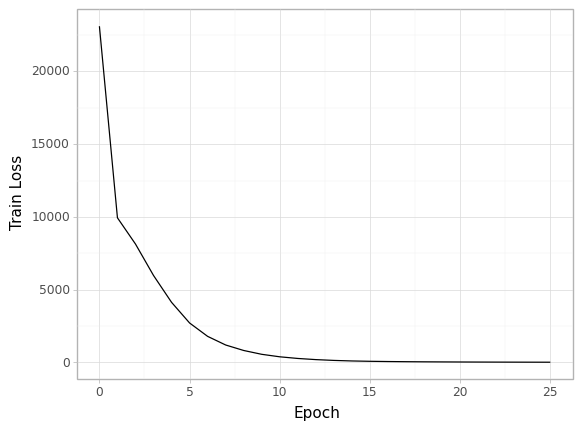

<ggplot: (8766205116151)>

In [27]:
(
    ggplot(train_scores, aes(x='Epoch', y='Train loss'))
        + geom_line(color='black') # line plot
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

In [28]:
valid_scores = pd.DataFrame(np.hstack([(range(0, cfg.epochs+1, cfg.check_epoch), total_logs[score], [score for i in range(0, cfg.epochs+1, cfg.check_epoch)]) for score in ['Valid Recall@25', 'Valid NDCG@25', 'Valid Coverage', 'Valid Score']])).T
valid_scores.columns = ['Epoch', 'Score', 'Metric']
valid_scores['Epoch'] = valid_scores['Epoch'].astype(int)
valid_scores['Score'] = valid_scores['Score'].astype(float)

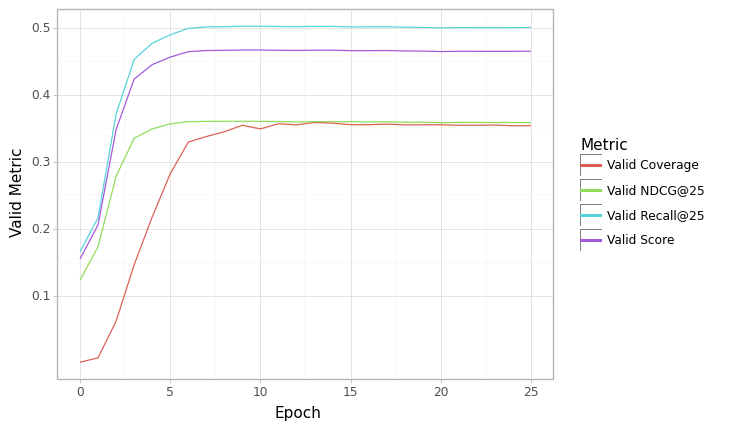

<ggplot: (8766205444081)>

In [29]:
(
ggplot(valid_scores)  # here
    + aes("Epoch", "Score", color='Metric', group='Metric')
    + geom_line()
    + scale_y_continuous(breaks=[0.1*c for c in range(1, 10, 1)])
    + theme_light()
    + labs(x='Epoch', y='Valid Metric')
)  

## 제출 
### 모든 유저에 대해 추천 결과 생성

In [42]:
model.load_state_dict(torch.load(os.path.join(saved_path, 'model(실험2_best_scores).pth')))

<All keys matched successfully>

In [43]:
submission_path = os.path.join(data_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission = valid_epoch(cfg, model, submission, mode='test')

100%|██████████| 8311/8311 [05:32<00:00, 24.99it/s] 


### 저장

In [44]:
submission.to_csv(os.path.join(output_path, '실험2_epoch25_submission.csv'), index = False)